In [323]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import shapely
from collections import Counter
from xgboost import XGBClassifier
from xgboost import callback
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import libpysal
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.cluster import KMeans


In [173]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [174]:
df15 = load_data(2015)
df16 = load_data(2016)
wt = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)
wv = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)

In [359]:

scaler = StandardScaler()
X15 = df15[df15.columns[:-4]]
Y15 = df15.y

X16 = df16[df16.columns[:-4]]
Y16 = df16.y

X15 = pd.DataFrame(scaler.fit_transform(X15))
X16 = pd.DataFrame(scaler.transform(X16))

In [384]:
class CA_cluster():
    def __init__(self, trans_model, rule_model, X_train, Y_train, X_val, Y_val, w_train, w_val, labels_train, labels_val):
        self.t0 = time.time()
        self.tm = trans_model
        self.rm = rule_model
        self.models = {}
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_val = X_val
        self.Y_val = Y_val
        self.w_train = w_train
        self.w_val = w_val
        
        self.labels_train = labels_train
        self.labels_val = labels_val
        
        self.t_idx = X_train.index
        self.v_idx = X_val.index

        
    def transition_fit(self):
#         print("fitting transition model: ", self.tm)
        for cluster in self.labels_train.index.unique(): #loop over clusters
        
            # Get data belonging to cluster
            x = self.X_train.loc[self.labels_train.loc[cluster]["X"]]
            y = self.Y_train.loc[self.labels_train.loc[cluster]["X"]]
            
            x_val = self.X_val.loc[self.labels_val.loc[cluster]["X"]]
            y_val = self.Y_val.loc[self.labels_val.loc[cluster]["X"]]
            
            
            oversample = SMOTE() #oversample
            try: x, y = oversample.fit_resample(x, y)
            except: pass
                                 
            self.tm.fit(x, y, eval_set = [(x_val, y_val)], eval_metric = "auc", callbacks = [callback.EarlyStopping(rounds=20,
                                            save_best=True)], verbose = False)
            self.models[cluster] = self.tm # add models to model dict
        
        
    def neighbor_function(self, X, idxs, w, labels):
        grid_transitions = pd.DataFrame()
        for cluster in labels.index.unique():
            x = X.loc[labels.loc[cluster]["X"]]

            df = pd.DataFrame(self.models[cluster].predict_proba(x)).set_index(x.index)[1]
            grid_transitions = pd.concat([grid_transitions, df])
            
        
        grid_transitions = grid_transitions[0]
        neighbors = [w.neighbors[x] for x in X.index] # get neighbors sorted by index 
        
        transitions = [grid_transitions.loc[x].values for x in neighbors] # get the trans probs of neighbors sorted by index
        n_function = np.zeros((len(transitions), w.max_neighbors + 1)) # create array to hold
        for i, (t, idx) in enumerate(zip(transitions, idxs)): # fill array
            n_function[i, 1:len(t) + 1] = t
            n_function[i, 0] = grid_transitions.loc[idx]

        return pd.DataFrame(n_function).set_index(X.index)
        
    
    def neighbor_fit(self):

            
        n_function = self.neighbor_function(self.X_train, self.t_idx, self.w_train, self.labels_train)
        oversample = SMOTE()
        x, y = oversample.fit_resample(n_function, self.Y_train)
        self.rm.fit(x, y)

    def val(self):
        n_func = self.neighbor_function(self.X_val, self.v_idx, self.w_val, self.labels_val)
        preds = self.rm.predict(n_func)
        acc = accuracy_score(self.Y_val, preds)
        AUC = roc_auc_score(self.Y_val, preds)
        print(AUC)
        f1 = f1_score(self.Y_val, preds)
        print("acc: {:.3f}, AUC: {:.3f}, f1: {:.3f}\n".format(
            acc, AUC, f1), time.time() - self.t0)
        
        return acc, AUC, f1, self.tm, self.rm 
        

In [386]:
for clusters in [3,5,7,10]:
    for md in [6, 10, 14, 16]:
        for nest in [100, 250, 500]:
            cluster_model = KMeans(n_clusters=clusters, random_state=0)
            labels15 = pd.DataFrame(cluster_model.fit_predict(X15))
            labels16 = pd.DataFrame(cluster_model.predict(X16))

            labels15["X"] = X15.index
            labels16["X"] = X16.index

            labels15 = labels15.set_index(0)
            labels16 = labels16.set_index(0)

            #predict
            tm = XGBClassifier(max_depth = md, n_estimators = nest)

            rm = RandomForestClassifier(max_depth = 10)
            gs = CA_cluster(tm,rm, X15, Y15, X16, Y16, wt, wv, labels15, labels16)

            gs.transition_fit()
            gs.neighbor_fit()

            with open("../results/XGB/resultscluster.csv", "a") as f:
                f.write(str(gs.val()).strip("(").strip(")") + "," + str(clusters) + "\n")

    

C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5981582196002146
acc: 0.683, AUC: 0.598, f1: 0.199
 121.2640540599823


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.6063939184758863
acc: 0.747, AUC: 0.606, f1: 0.216
 126.50687003135681


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.6044152295657876
acc: 0.719, AUC: 0.604, f1: 0.209
 124.79298210144043


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5750917856159222
acc: 0.785, AUC: 0.575, f1: 0.194
 127.21291422843933


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5759775871795978
acc: 0.768, AUC: 0.576, f1: 0.192
 143.2252175807953


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5601440589584435
acc: 0.816, AUC: 0.560, f1: 0.181
 130.00259518623352


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5672934918179633
acc: 0.785, AUC: 0.567, f1: 0.186
 134.7847604751587


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5731413035727786
acc: 0.821, AUC: 0.573, f1: 0.198
 161.61108374595642


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.575802386780623
acc: 0.767, AUC: 0.576, f1: 0.192
 175.3623161315918


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5710407380434886
acc: 0.814, AUC: 0.571, f1: 0.194
 139.76443529129028


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5776655408345235
acc: 0.787, AUC: 0.578, f1: 0.197
 143.9169843196869


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5748162499922382
acc: 0.777, AUC: 0.575, f1: 0.192
 170.11182832717896


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.588394185271354
acc: 0.608, AUC: 0.588, f1: 0.186
 123.00701570510864


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5936462685846395
acc: 0.579, AUC: 0.594, f1: 0.187
 135.9630250930786


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5865739080094761
acc: 0.626, AUC: 0.587, f1: 0.186
 144.69388842582703


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5834626920557309
acc: 0.653, AUC: 0.583, f1: 0.186
 140.43902325630188


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5708263540833758
acc: 0.622, AUC: 0.571, f1: 0.176
 158.51796698570251


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5774921355517556
acc: 0.644, AUC: 0.577, f1: 0.182
 148.00523924827576


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.570007987089995
acc: 0.677, AUC: 0.570, f1: 0.179
 162.46025156974792


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5603461419583193
acc: 0.697, AUC: 0.560, f1: 0.173
 155.36266326904297


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5697592163546741
acc: 0.691, AUC: 0.570, f1: 0.179
 178.9549160003662


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5709085910053437
acc: 0.700, AUC: 0.571, f1: 0.181
 165.6450390815735


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5737945493032639
acc: 0.725, AUC: 0.574, f1: 0.185
 177.93862175941467


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5628586572289462
acc: 0.719, AUC: 0.563, f1: 0.176
 186.9037160873413


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5555097163313227
acc: 0.796, AUC: 0.556, f1: 0.173
 105.7068543434143


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.553905000154939
acc: 0.795, AUC: 0.554, f1: 0.172
 102.61191391944885


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5569273872845798
acc: 0.794, AUC: 0.557, f1: 0.175
 108.3511209487915


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5573676321772756
acc: 0.797, AUC: 0.557, f1: 0.176
 112.6840193271637


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5568077913458154
acc: 0.796, AUC: 0.557, f1: 0.175
 105.16843175888062


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5540938846364745
acc: 0.798, AUC: 0.554, f1: 0.172
 116.8960211277008


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5571876202783037
acc: 0.791, AUC: 0.557, f1: 0.175
 115.7487804889679


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5560187642025695
acc: 0.801, AUC: 0.556, f1: 0.174
 129.6486988067627


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5538540453399857
acc: 0.798, AUC: 0.554, f1: 0.172
 105.80248069763184


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5573245199601767
acc: 0.801, AUC: 0.557, f1: 0.176
 133.7864694595337


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5561525886443833
acc: 0.793, AUC: 0.556, f1: 0.174
 145.2809443473816


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5544221113350494
acc: 0.792, AUC: 0.554, f1: 0.172
 138.3740530014038


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5869212924236356
acc: 0.599, AUC: 0.587, f1: 0.185
 119.83488249778748


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5851224535577687
acc: 0.577, AUC: 0.585, f1: 0.182
 121.2220766544342


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5797160638210308
acc: 0.572, AUC: 0.580, f1: 0.179
 123.22877264022827


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5899777426190045
acc: 0.630, AUC: 0.590, f1: 0.189
 130.0364010334015


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5757521382408985
acc: 0.522, AUC: 0.576, f1: 0.175
 128.4641535282135


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.58876044783382
acc: 0.580, AUC: 0.589, f1: 0.185
 124.8479814529419


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.591345812451497
acc: 0.747, AUC: 0.591, f1: 0.203
 116.59296989440918


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.600592941597189
acc: 0.608, AUC: 0.601, f1: 0.193
 135.20179319381714


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5817200020705636
acc: 0.625, AUC: 0.582, f1: 0.183
 132.21528244018555


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5896015774892663
acc: 0.546, AUC: 0.590, f1: 0.183
 136.4278166294098


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5860691713599391
acc: 0.777, AUC: 0.586, f1: 0.204
 113.00898671150208


C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: Th

0.5778231432090445
acc: 0.709, AUC: 0.578, f1: 0.187
 123.41086792945862


In [376]:
def labelchecker(labels):
    for i in Counter(labels15.index.values):
        print(Counter(labels15.index.values)[i])

6982
20247
5684
4661
3904
14822
67


In [347]:
cluster_model = KMeans(n_clusters=5, random_state=0)
labels15 = pd.DataFrame(cluster_model.fit_predict(X15))
labels16 = pd.DataFrame(cluster_model.predict(X16))

labels15["X"] = X15.index
labels16["X"] = X16.index

labels15 = labels15.set_index(0)
labels16 = labels16.set_index(0)

print(labels15.index.unique(), labels16.index.unique())

Int64Index([0, 3, 2, 1, 4], dtype='int64', name=0) Int64Index([0, 2], dtype='int64', name=0)


In [312]:
gs.grid_transitions[0]

0        0.062524
1        0.140539
2        0.075133
3        0.062245
4        0.019365
           ...   
55448    0.408658
55751    0.459530
55753    0.229776
55799    0.154112
55800    0.571284
Name: 0, Length: 56367, dtype: float32

In [287]:
transitions = [gs.grid_transitions.loc[x].values for x in gs.neighbors]
n_function = np.zeros((len(transitions), 9)) # create array to hold


In [295]:
for i in transitions:
    print(len(i))
    n_function[0, 1:len(i) + 1] = i
    
    break

0


ValueError: could not broadcast input array from shape (0,1) into shape (0)

array([[<AxesSubplot:title={'center':'bijeenkomstfunctiesum'}>,
        <AxesSubplot:title={'center':'gezondheidszorgfunctiesum'}>,
        <AxesSubplot:title={'center':'industriefunctiesum'}>,
        <AxesSubplot:title={'center':'kantoorfunctiesum'}>,
        <AxesSubplot:title={'center':'logiesfunctiesum'}>,
        <AxesSubplot:title={'center':'onderwijsfunctiesum'}>],
       [<AxesSubplot:title={'center':'sportfunctiesum'}>,
        <AxesSubplot:title={'center':'winkelfunctiesum'}>,
        <AxesSubplot:title={'center':'woonfunctiesum'}>,
        <AxesSubplot:title={'center':'oppervlakteVerblijfsobjectmean'}>,
        <AxesSubplot:title={'center':'inwoner_g'}>,
        <AxesSubplot:title={'center':'geboorte_g'}>],
       [<AxesSubplot:title={'center':'inw_014_g'}>,
        <AxesSubplot:title={'center':'inw_1524_g'}>,
        <AxesSubplot:title={'center':'inw_2544_g'}>,
        <AxesSubplot:title={'center':'inw_4564_g'}>,
        <AxesSubplot:title={'center':'inw_65_g'}>,
        <

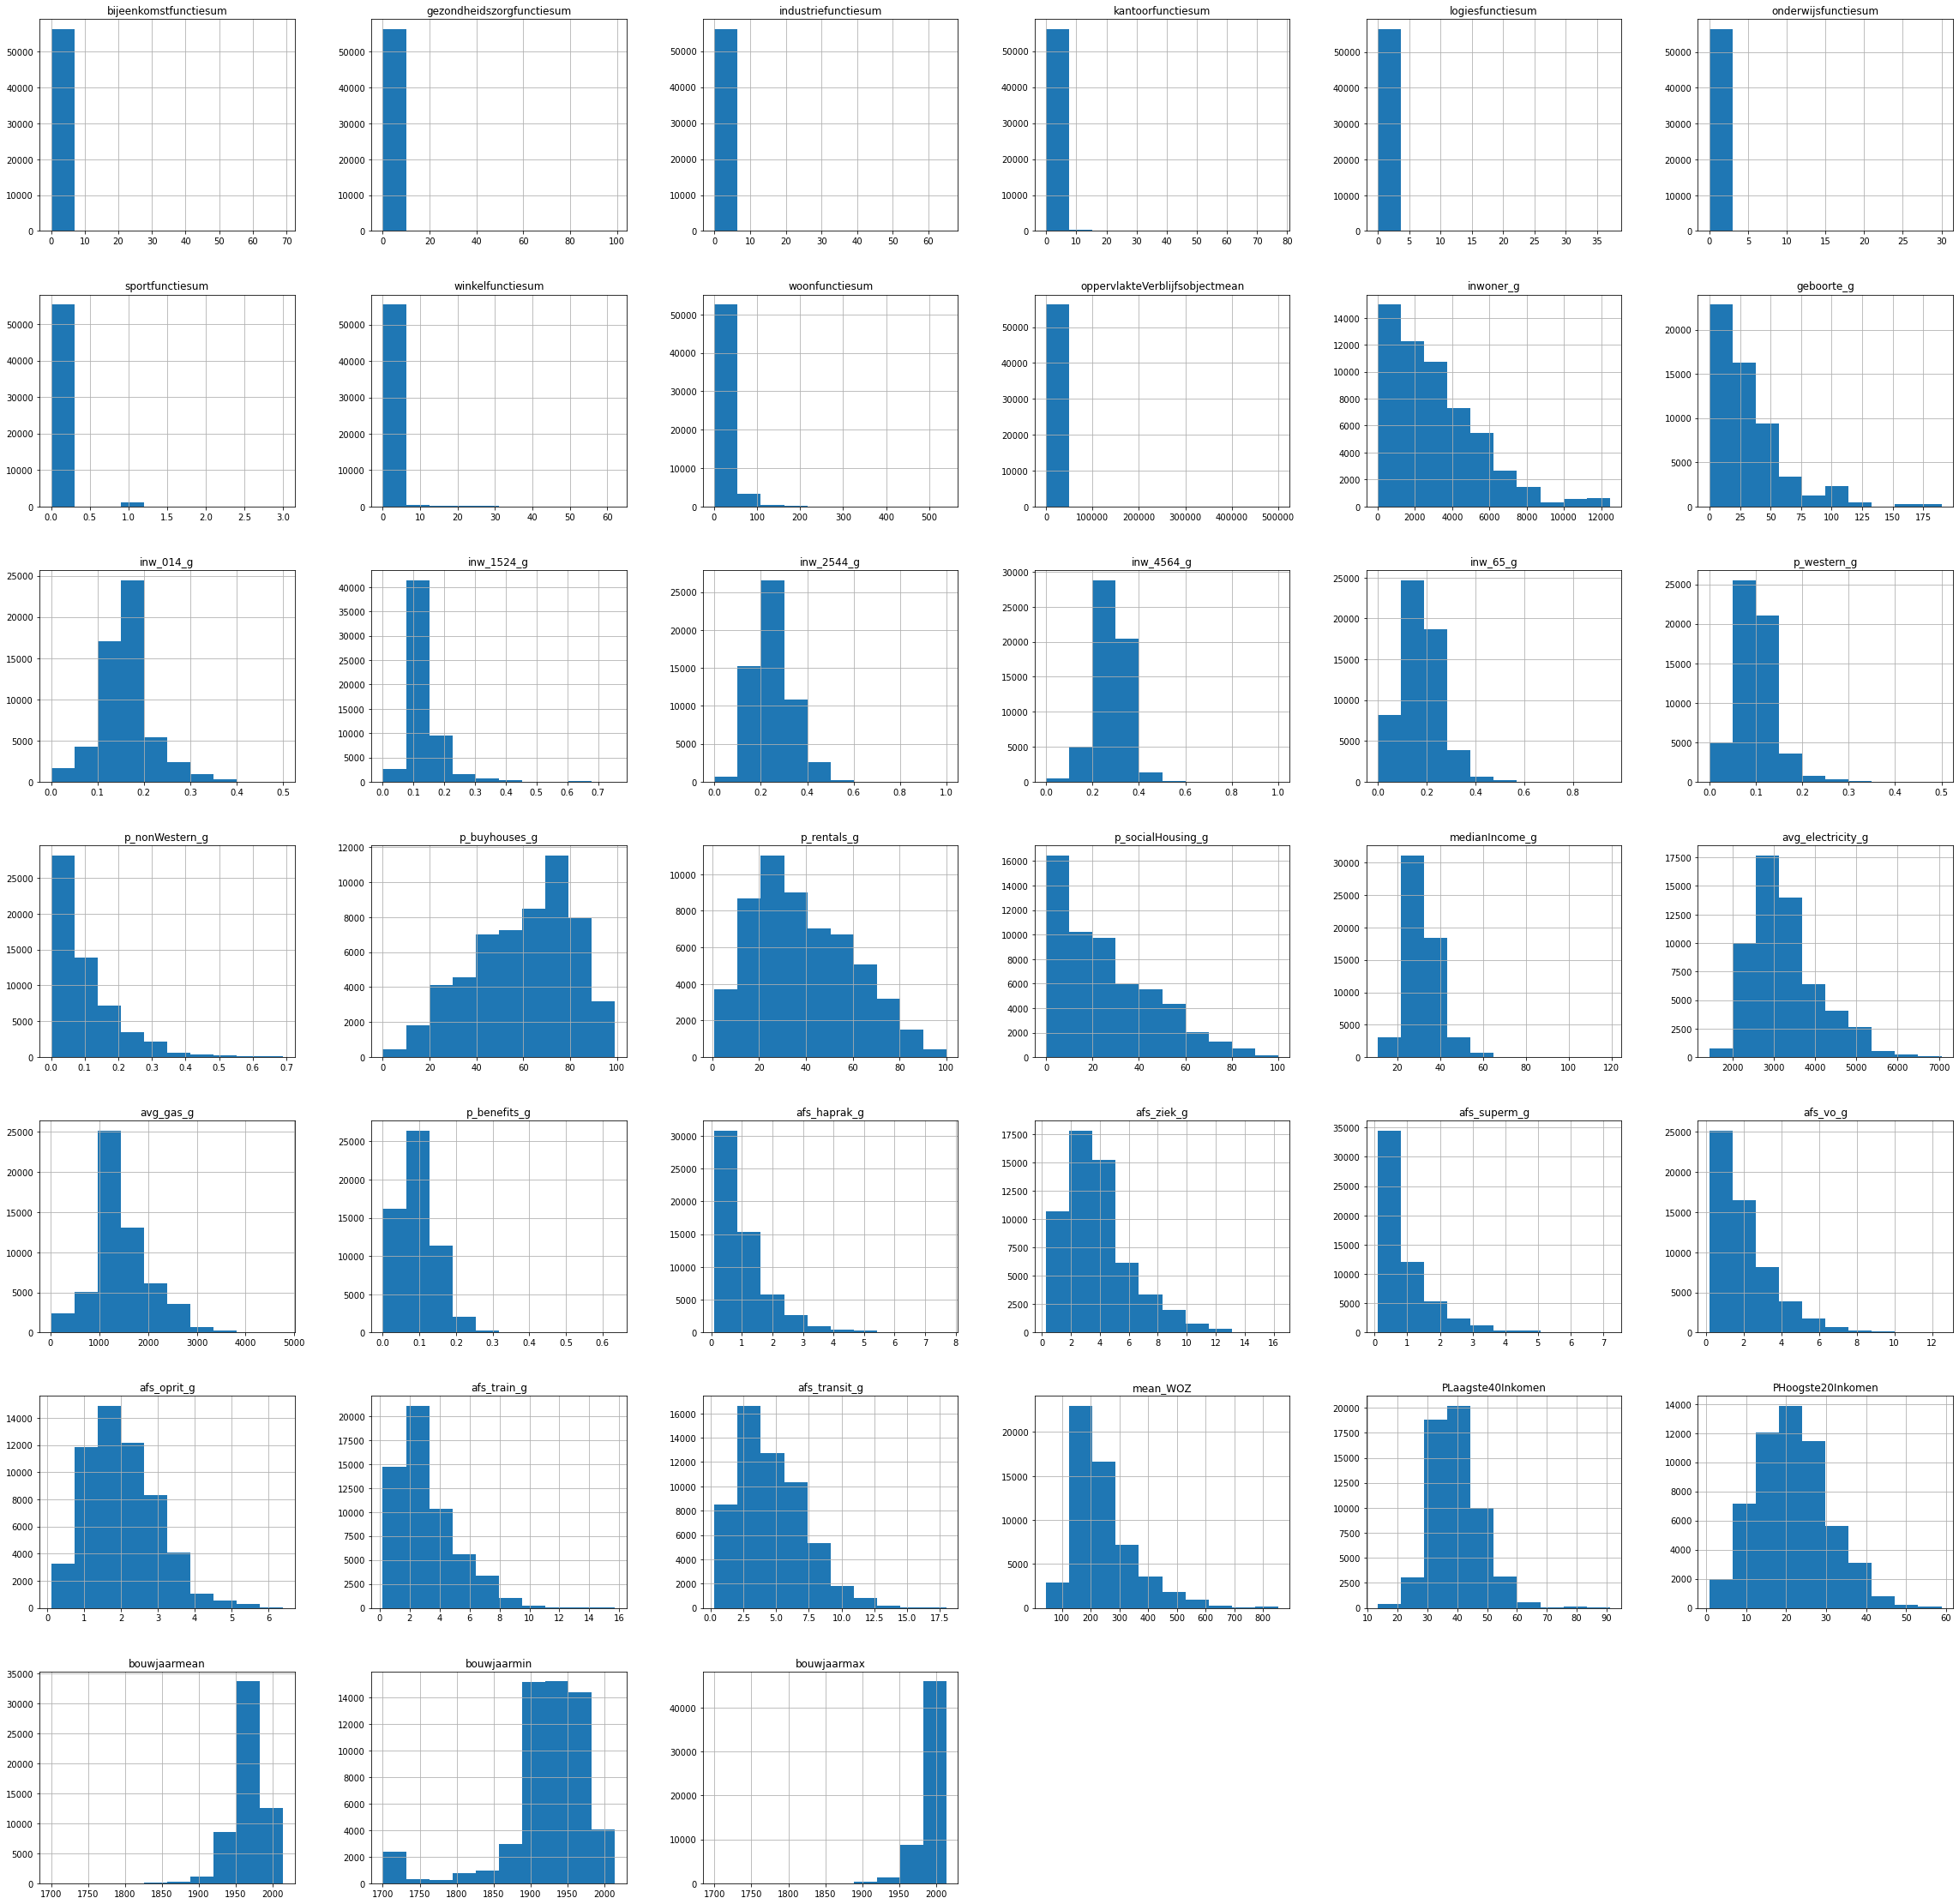

In [191]:
X.hist(figsize = (40,40))

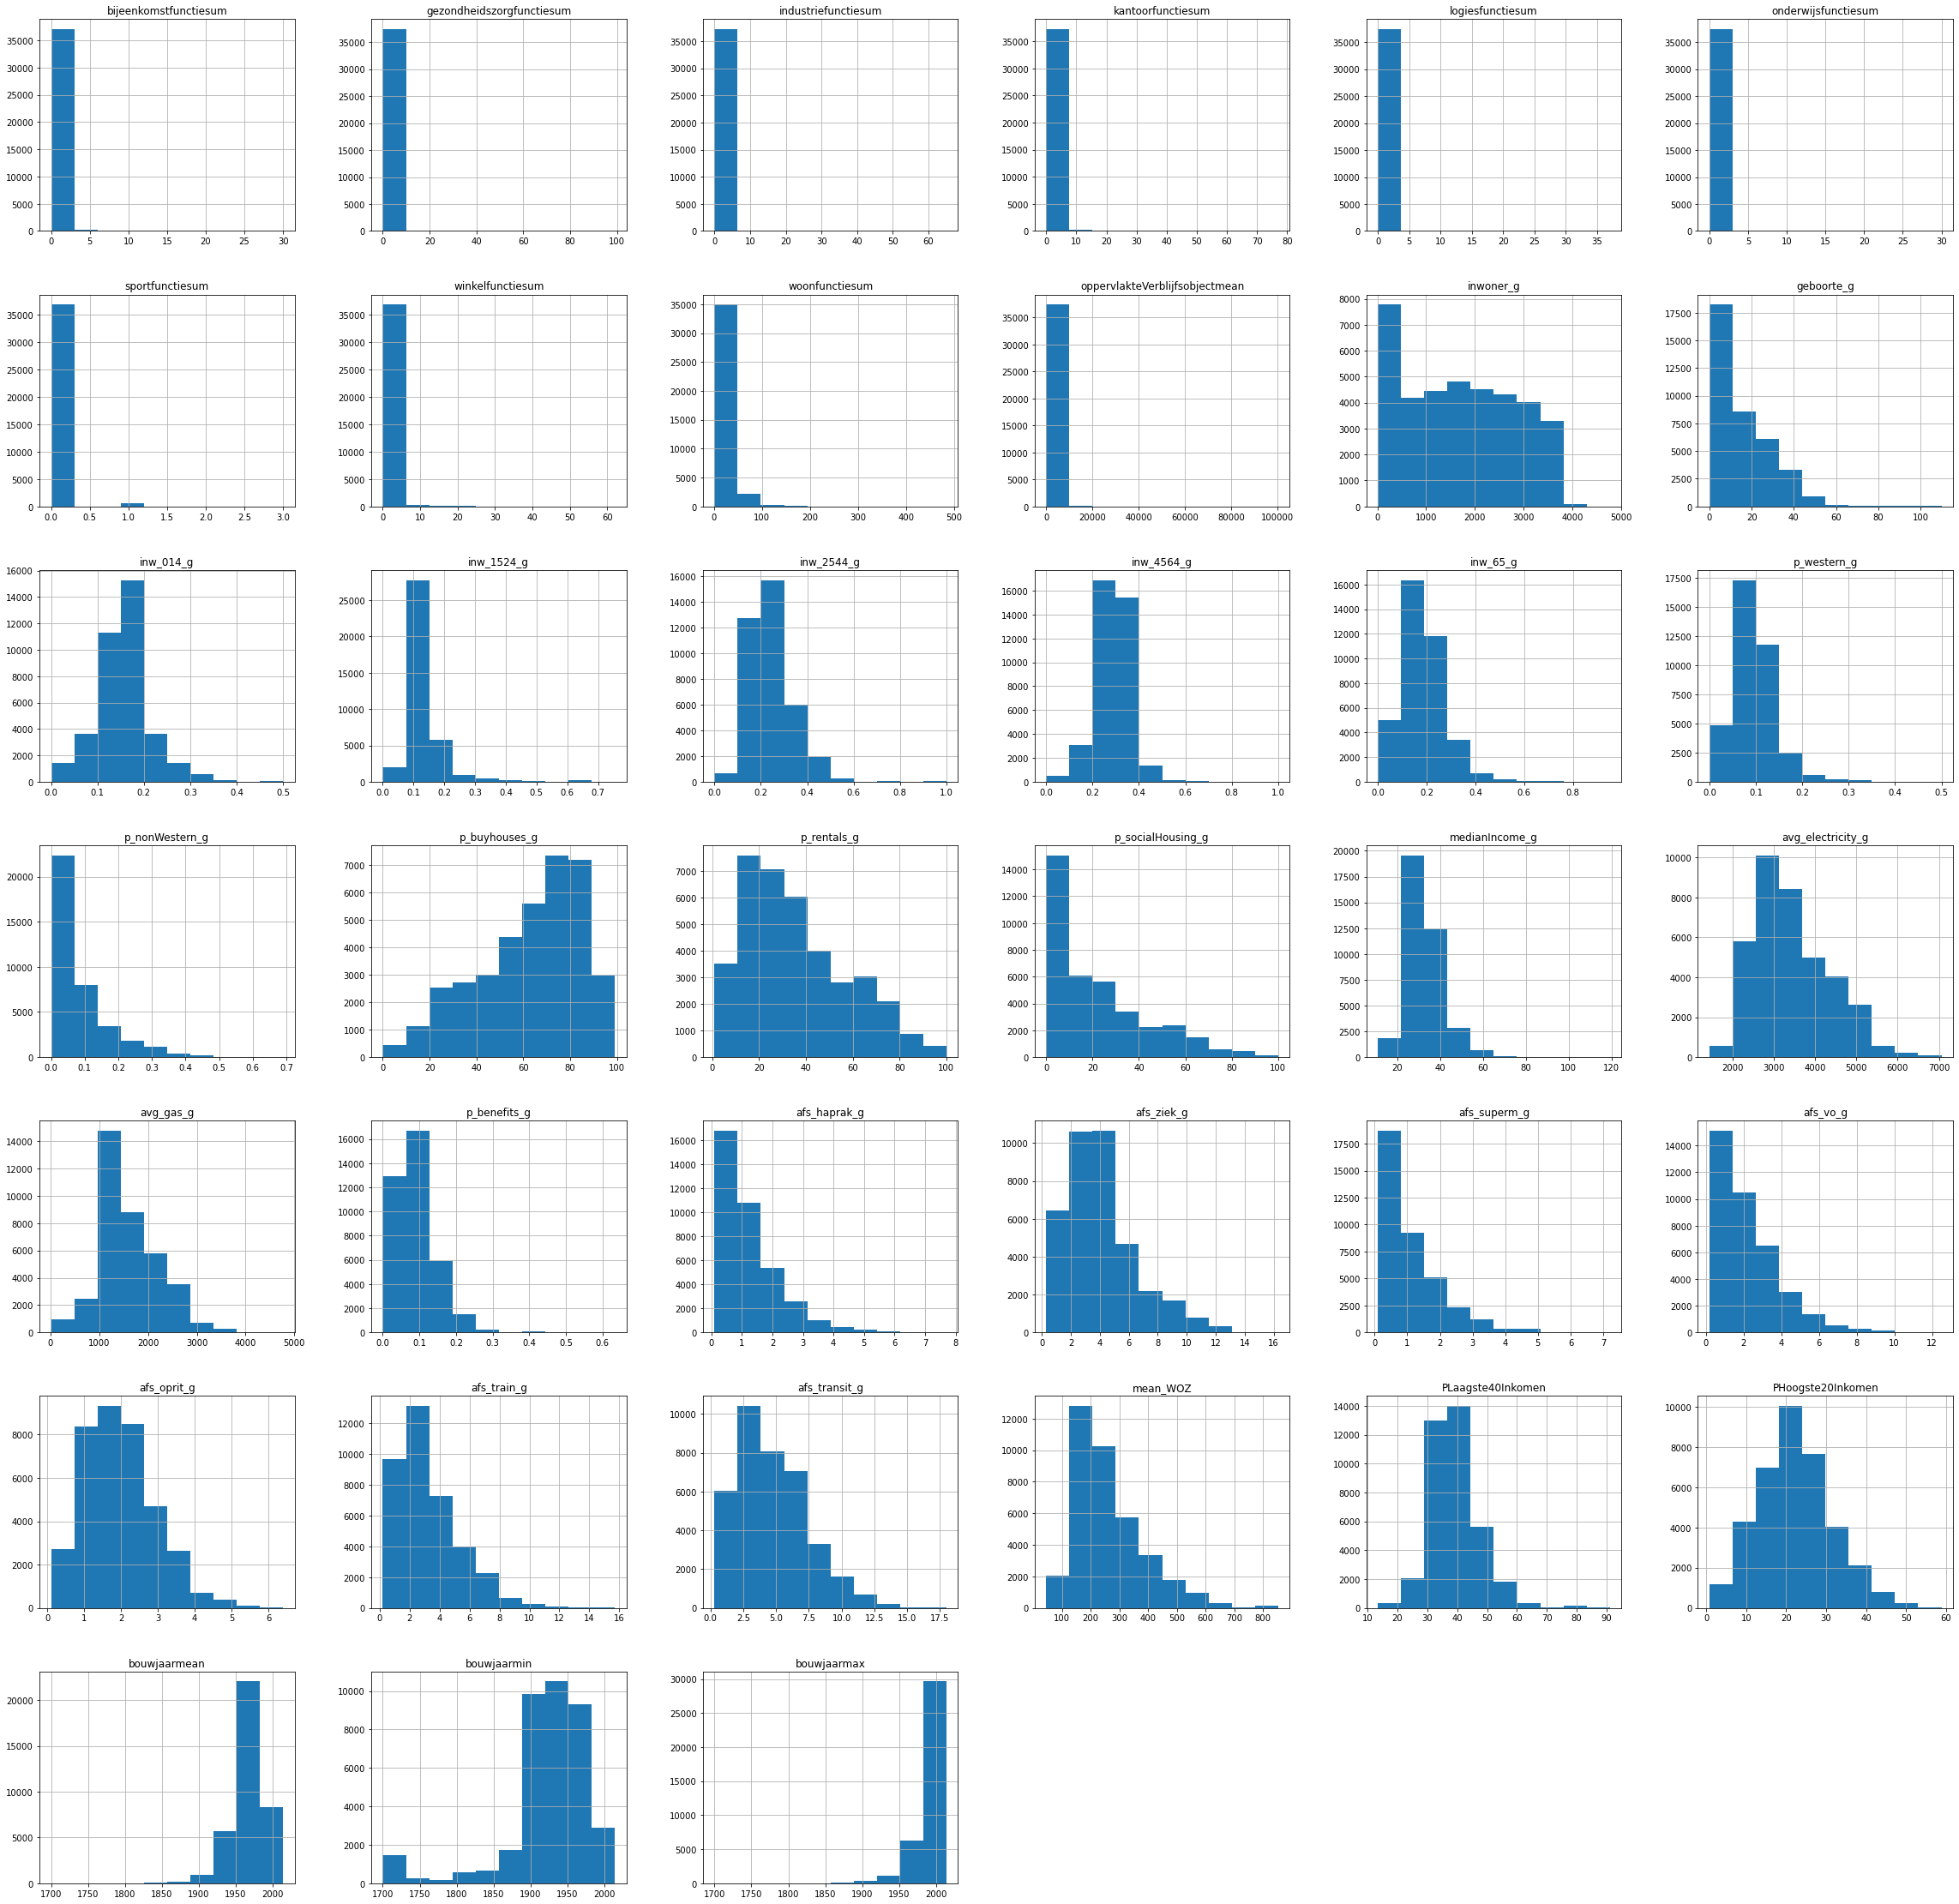

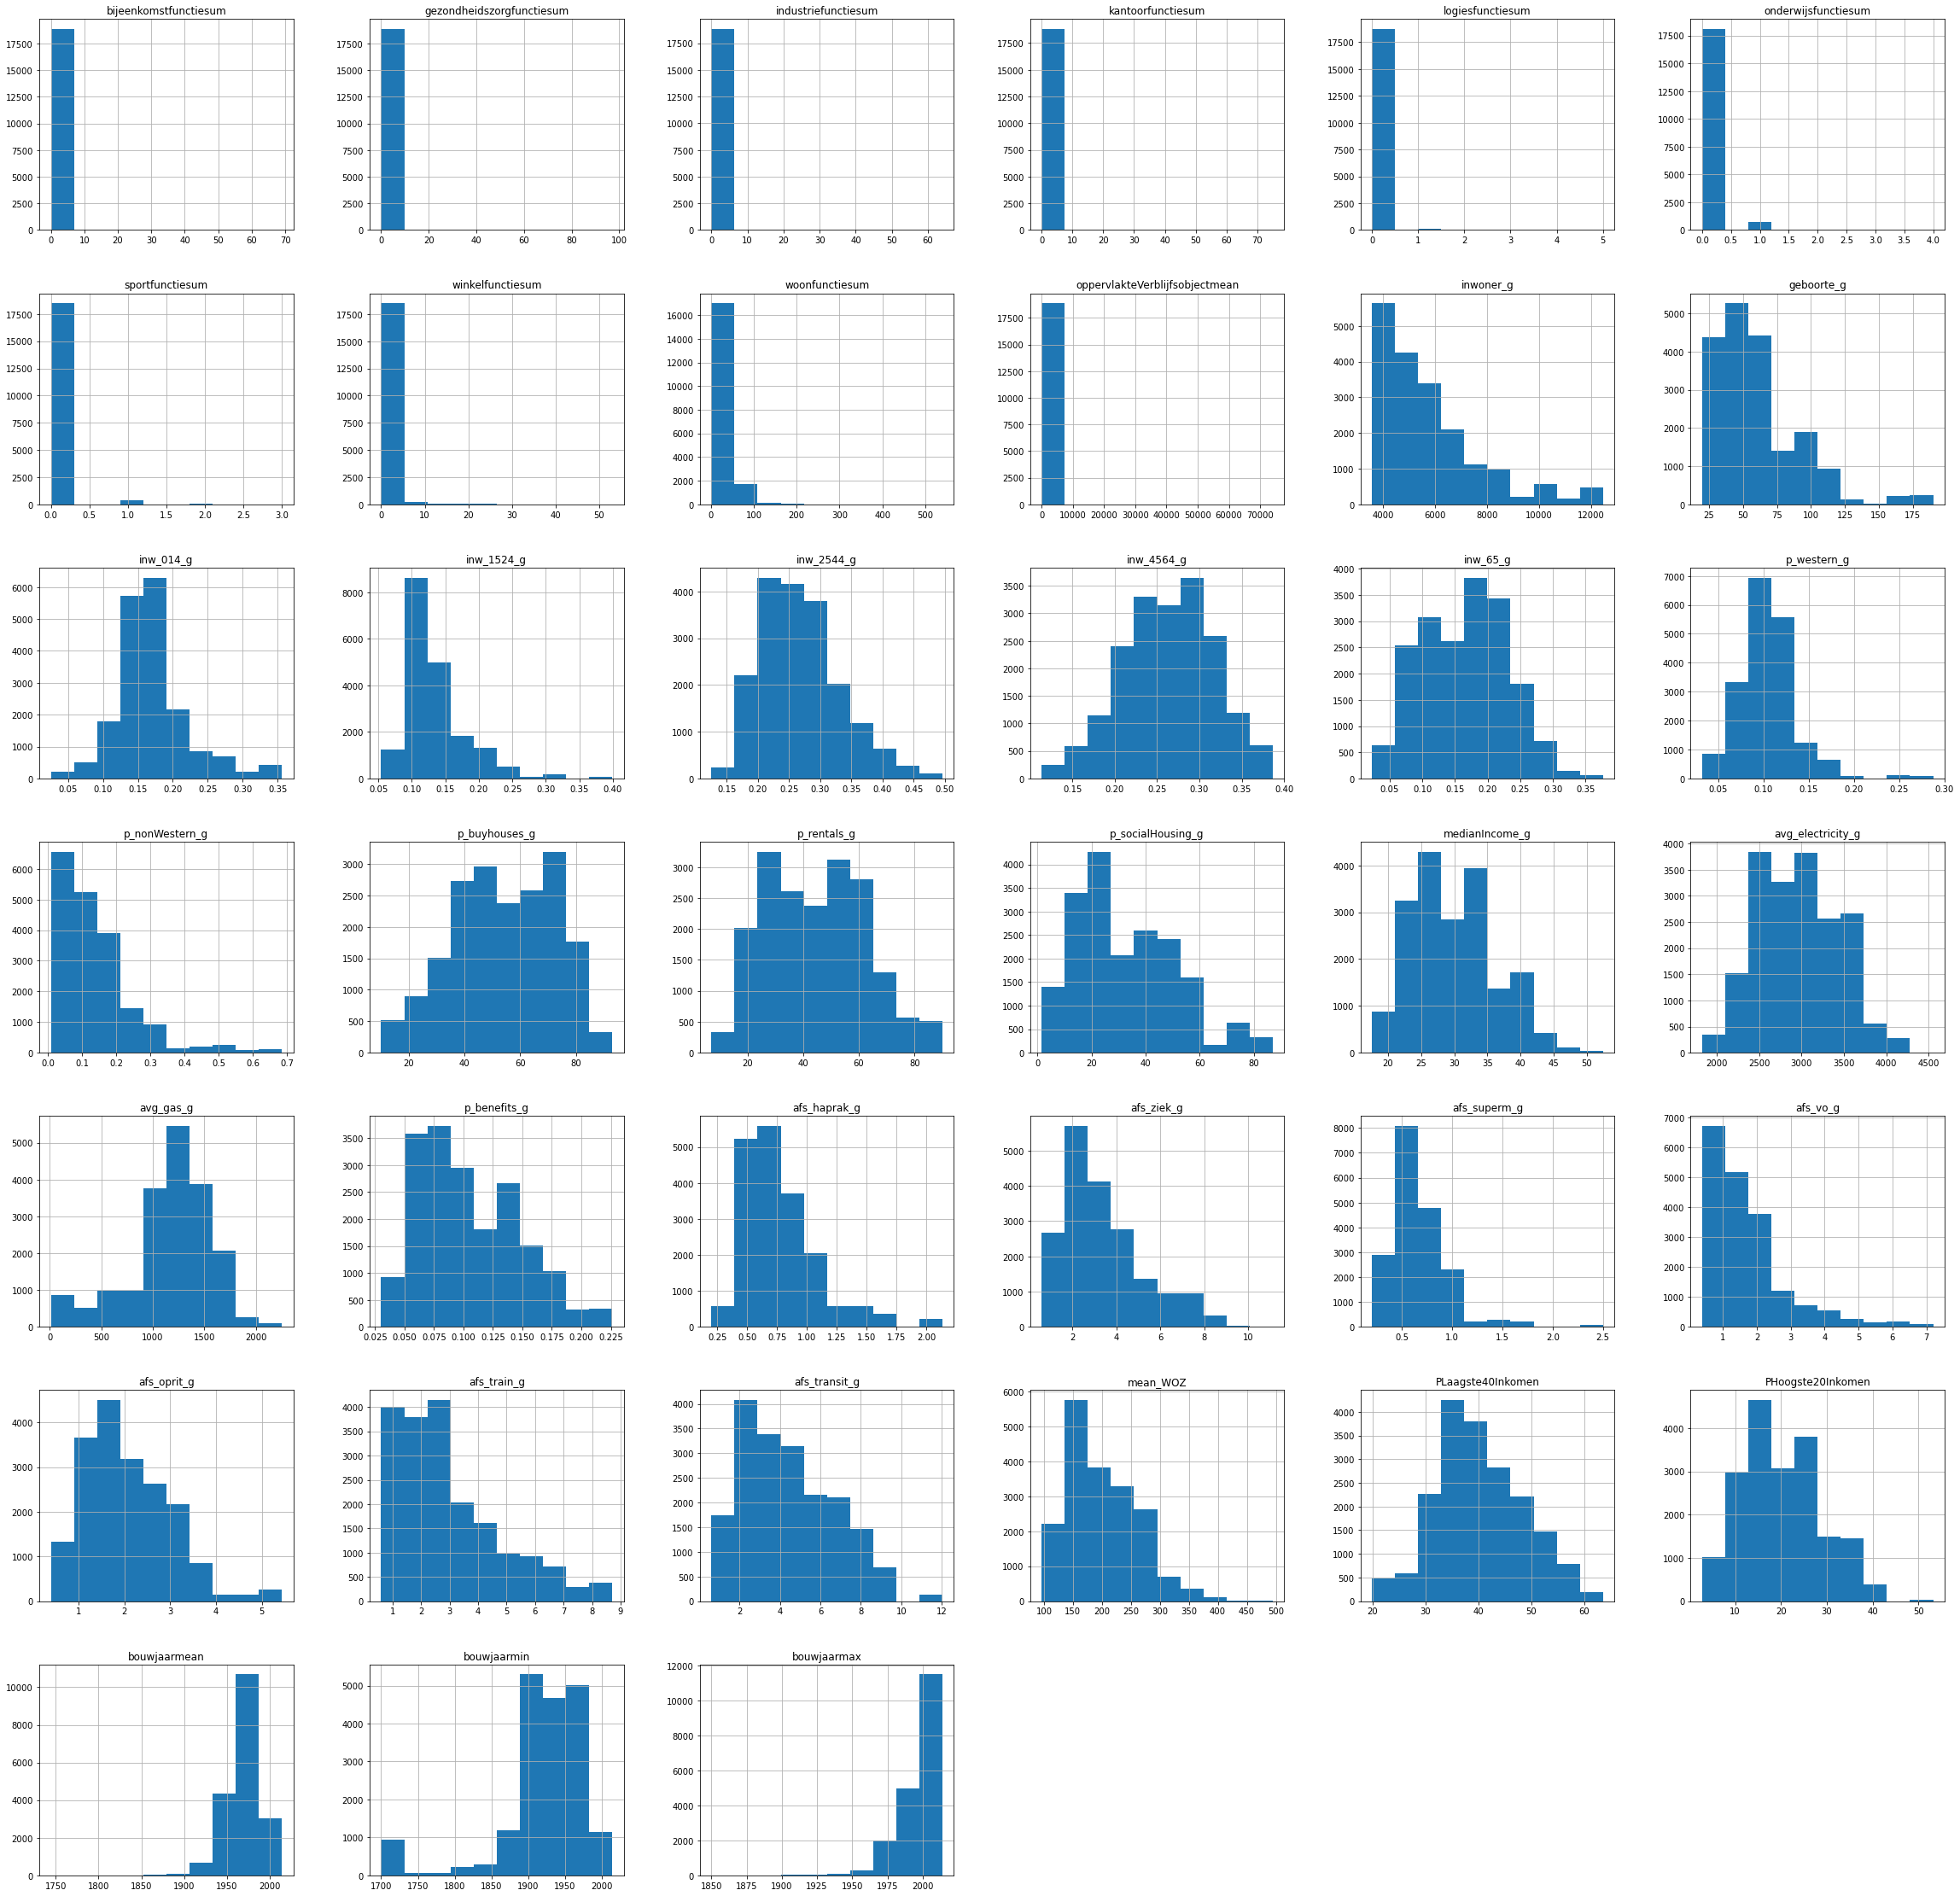

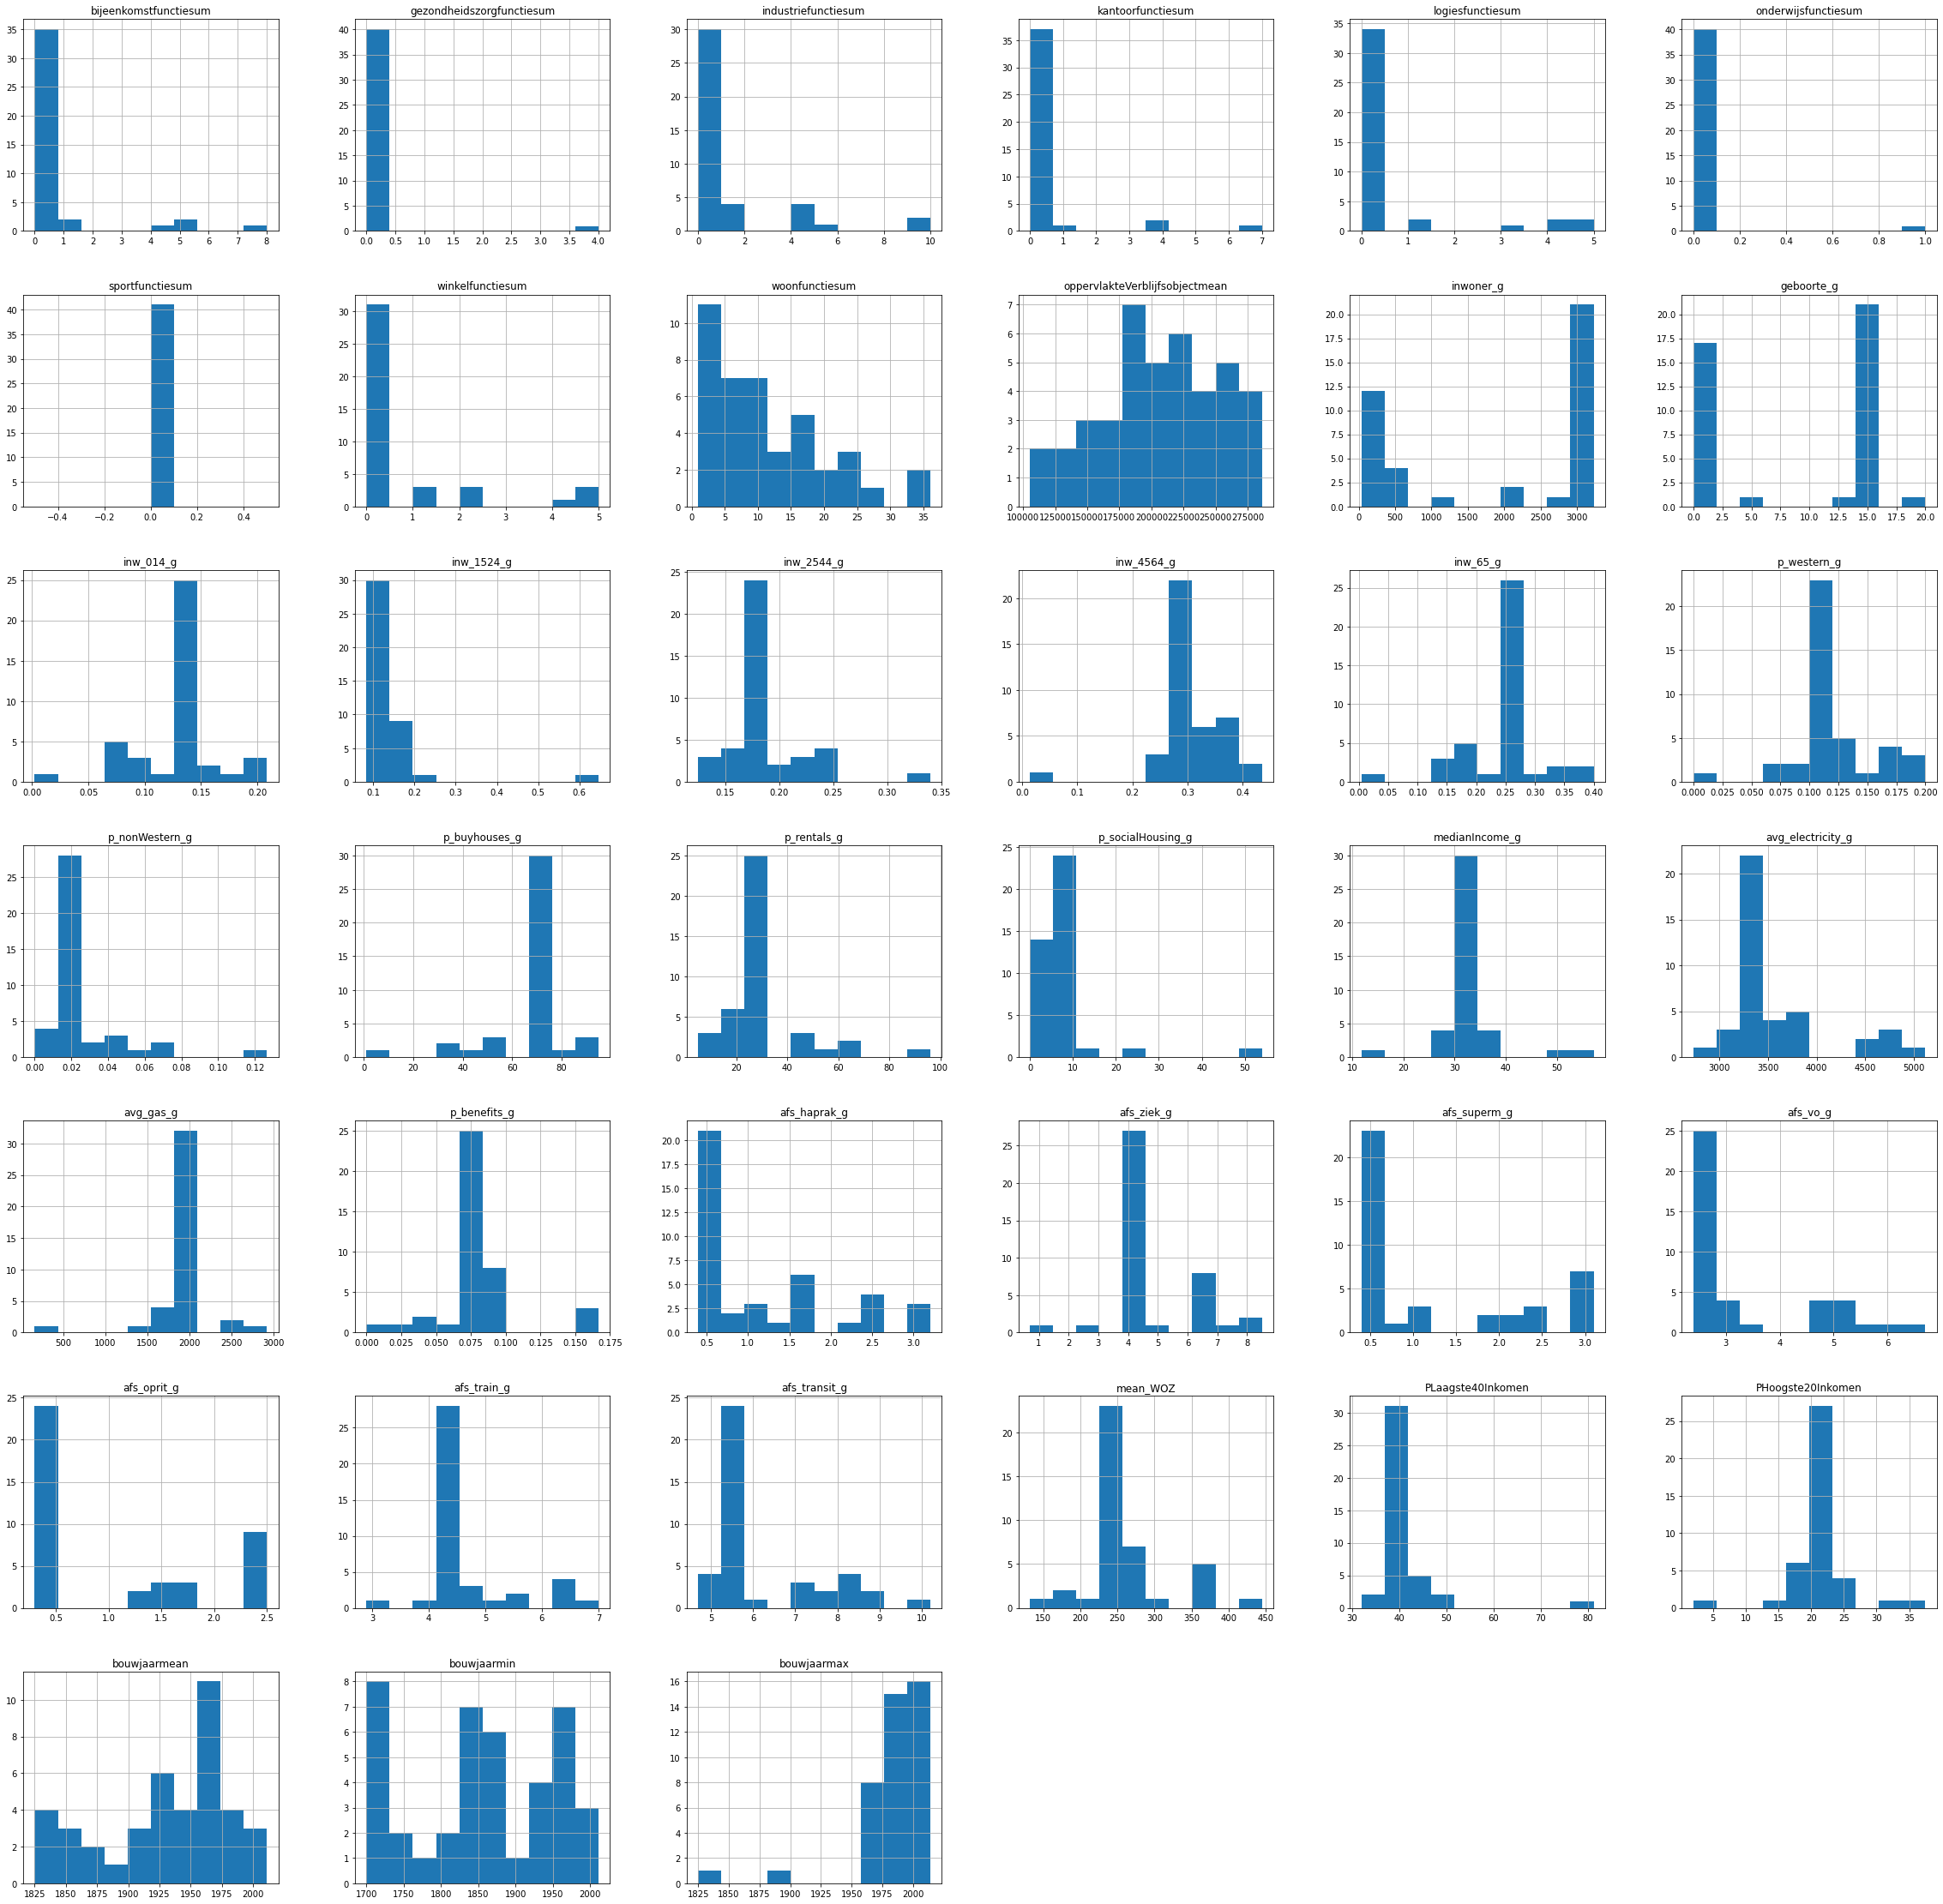

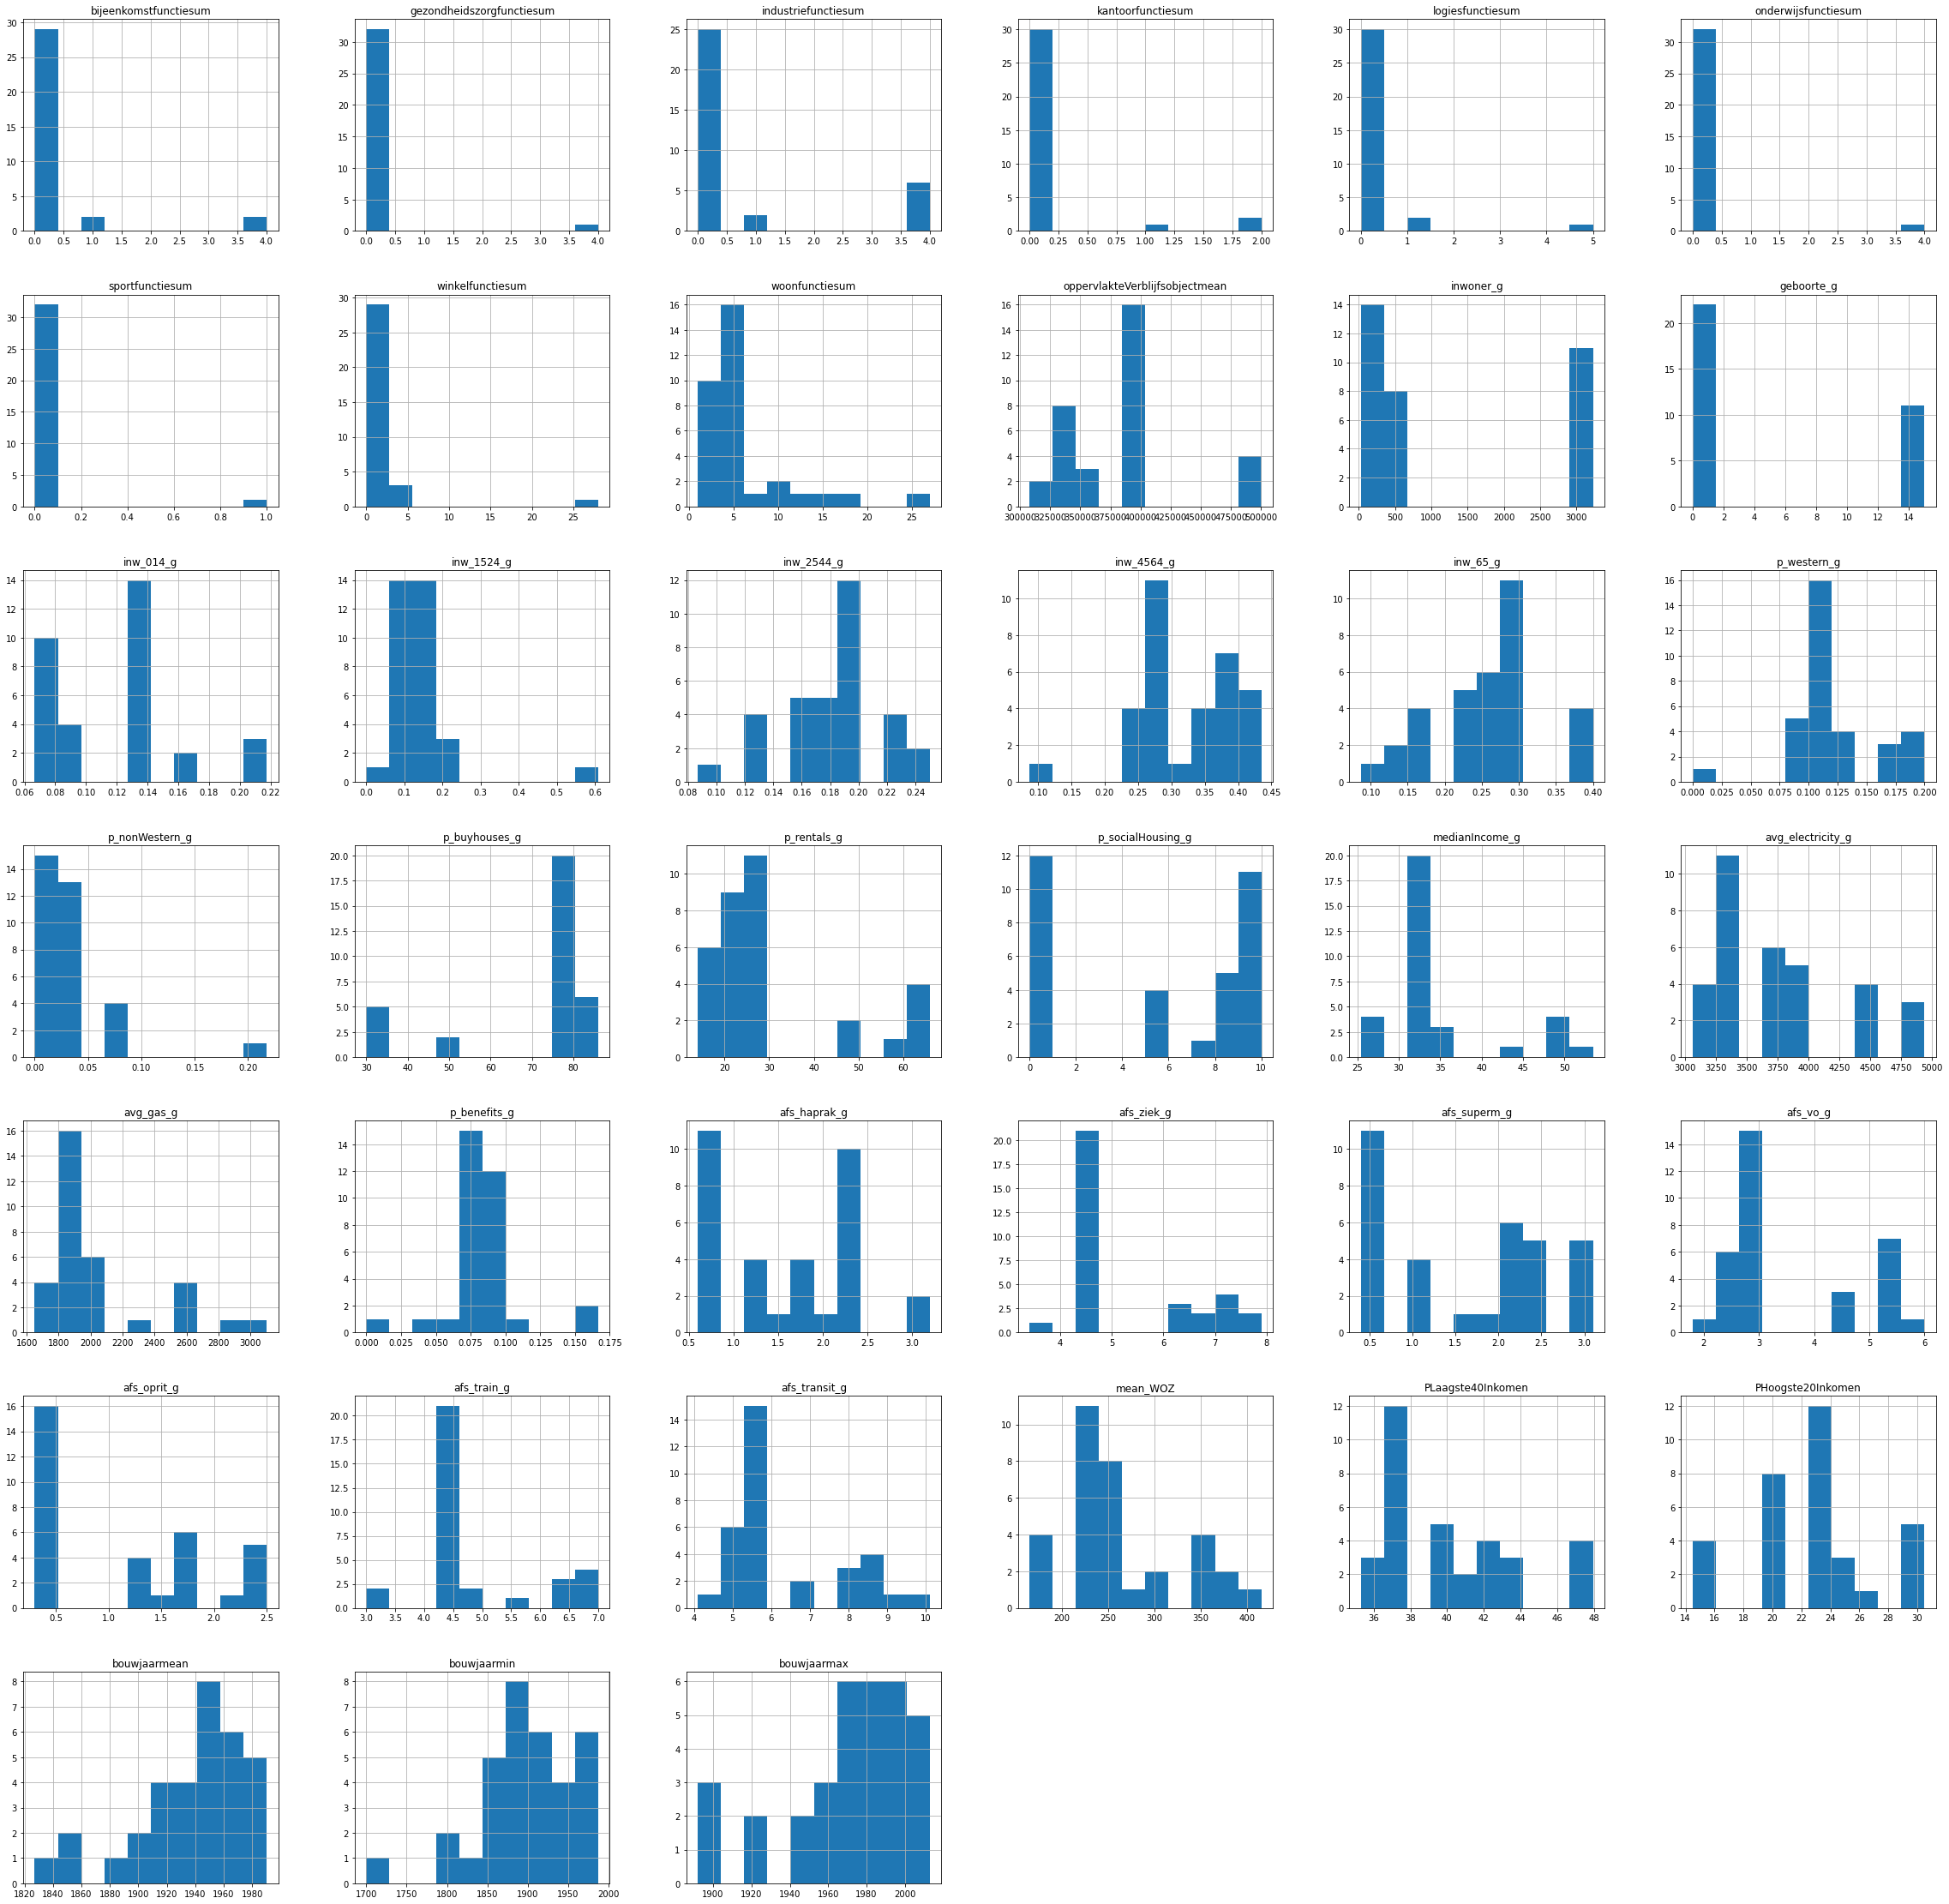

In [193]:
for cluster in labels15.index.unique():
    x = X.loc[labels15.loc[cluster]["X"]]
    x.hist(figsize = (40,40))